In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF

In [2]:
from torch.nn.modules.batchnorm import BatchNorm2d
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
      super(DoubleConv, self).__init__()

      self.conv = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, 3, 1, 1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_channels, out_channels, 3, 1, 1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True)
      )
    def forward(self, x):
        return self.conv(x)

In [3]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()

        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)


        # Down path of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature


        # Up path of UNET
        for feature in reversed(features):

            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))

            self.ups.append(DoubleConv(feature*2, feature))


        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)


    def forward(self, x):

        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.maxpool(x)


        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):

            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])


            concat_skip = torch.cat((skip_connection, x), dim=1)

            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [4]:
x = torch.randn(3,1,161,161)
model = UNET(in_channels = 1, out_channels = 1)

In [5]:
print(x)

tensor([[[[-0.6484,  1.3507, -2.2428,  ...,  0.0508, -0.1889,  1.6738],
          [ 0.6600,  1.0258,  1.3095,  ...,  0.5676, -0.4724,  0.7071],
          [-0.6763,  0.4743,  0.7793,  ..., -0.1118, -1.2365,  0.4483],
          ...,
          [ 0.6204, -0.6456,  1.9652,  ..., -0.6822,  1.0335,  1.0648],
          [ 0.9215, -0.0044, -1.8545,  ..., -0.3011, -0.3935,  0.3915],
          [ 0.0130, -1.0658,  2.3228,  ...,  1.0945,  0.4096,  1.9574]]],


        [[[-0.9539, -1.8138, -0.8389,  ...,  0.2222, -0.8840, -0.0092],
          [ 0.8219, -0.2483,  0.0612,  ...,  1.2824, -0.5606, -0.7574],
          [ 0.9326,  0.4480, -0.2091,  ...,  1.8709, -0.3815,  0.5387],
          ...,
          [ 0.5019, -0.7513,  1.7856,  ..., -0.0426,  0.3133,  0.9228],
          [-1.6395, -0.2911,  1.5095,  ...,  0.4317, -0.6537, -0.6747],
          [ 1.0150,  0.0528,  0.5817,  ...,  0.7481,  0.1511, -1.0827]]],


        [[[ 0.2377,  0.1167,  0.6993,  ..., -0.2762, -0.4260,  0.0594],
          [ 0.6621,  0.316

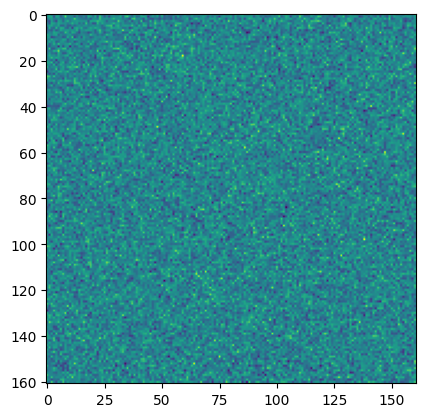

In [6]:
import matplotlib.pyplot as plt

plt.imshow(x[0].reshape(161,161))

In [7]:
with torch.no_grad():
    preds = model(x)
    print(preds)

tensor([[[[-3.8760e-01,  1.1601e-01, -4.7177e-04,  ...,  1.4146e-01,
           -3.5386e-01,  1.9202e-03],
          [-4.6730e-01,  1.9136e-02,  1.6785e-01,  ...,  5.2912e-02,
            1.5089e-01, -2.6866e-02],
          [-3.2802e-01, -3.7885e-01,  4.0815e-01,  ...,  7.2987e-01,
            9.7718e-02, -6.2618e-02],
          ...,
          [-3.3725e-01, -2.7465e-01,  8.1199e-03,  ..., -7.1865e-03,
            1.7224e-01,  3.7275e-01],
          [ 3.1836e-01, -2.1297e-02,  4.4461e-04,  ...,  3.5530e-01,
            3.0447e-01,  2.8079e-02],
          [-3.2302e-01,  9.3049e-02, -4.1883e-01,  ...,  1.1632e-01,
           -1.4774e-01, -1.9207e-01]]],


        [[[-1.6746e-01,  1.0752e-02,  3.0480e-01,  ..., -1.5465e-01,
           -1.9698e-01, -1.4854e-01],
          [-1.4037e-01, -2.4079e-01, -6.1733e-03,  ...,  4.7371e-01,
            5.7661e-02,  1.2568e-02],
          [-3.2341e-01,  2.6310e-01,  6.2234e-01,  ..., -1.9748e-01,
            5.7911e-02, -5.7297e-03],
          ...,
   

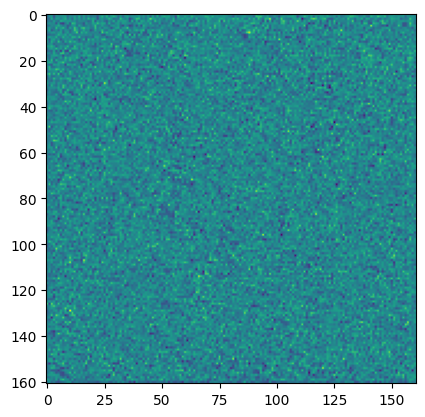

In [8]:
plt.imshow(preds[0].reshape(161,161))

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cuda")
unet = model = UNET(in_channels = 1, out_channels = 1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr = 0.001)

In [10]:
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, num_samples, image_size):

        self.num_samples = num_samples
        self.image_size = image_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image = torch.randn(1, self.image_size, self.image_size)
        target_mask = torch.randint(0, 2, (1, self.image_size, self.image_size)).float()

        return image, target_mask

In [11]:
dataset = CustomImageDataset(1000, 256)

batch_size = 6
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

In [12]:
num_epochs = 5

for epoch in range(num_epochs):
    for batch in dataloader:
        inputs, targets = batch

        optimizer.zero_grad()

        outputs = unet(inputs.to(device))

        loss = criterion(outputs, targets.to(device))

        loss.backward()
        optimizer.step()

        print(f"Epoch: {epoch}, Loss: {loss.item()}")

Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Loss: -0.0
Epoch: 0, Los